In [116]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os 
import random
from scipy import ndimage

%matplotlib inline

In [3]:
def crawl_folder(folder_path): #search_str 찾고자 하는 string 
    search_path_list=[]
    fileList = os.walk(folder_path).next()[2]
    subFolder_list = os.walk(folder_path).next()[1]
    if(len(fileList)!=0):
        for j in range(len(fileList)):
            search_path_list.append(folder_path+'/'+fileList[j])
    if len(subFolder_list)==0:
        return search_path_list
    else: 
        for i in range(len(subFolder_list)):
            search_path_list.extend(crawl_folder(folder_path+'/'+subFolder_list[i] ))
        return search_path_list

In [4]:
def aug_8_times(x,labels):
    """
    
    
    x shape is [n_batch , row ,col , color_ch ]
    x type is numpy 
    this code need too many time to run 
    we should find solution using parallel method to less run time maybe 
    
    return x,np_rot90,np_rot180,np_rot270,lr_x,np_lr_rot90 ,np_lr_rot180 , np_lr_rot270 
    
    """
    n_classes=np.shape(labels)[1]

    n_batch,row,col,ch=np.shape(x)
    lr_x = np.flipud(x)
    
    aug_np_imgs=np.zeros(shape =[n_batch*8, row ,col ,ch] )
    aug_np_labels=np.zeros(shape =[n_batch*8 ,n_classes ])
    

    for batch_ind in range(n_batch):
        for i in range(4):
            aug_np_labels[(batch_ind*8)+int(i),:]=labels[int(batch_ind) , :]
            
    
    rot_imgs=x
    rot_labs=labels
    for i in range(4):
        rot_imgs[i*n_batch:(i+1)*n_batch,:,:,:]=np.rot90(rot_imgs[:,:,:,:])
        aug_np_labels[i*n_batch:(i+1)*n_batch,:]=labels    

    aug_images=np.concatenate((x,np_rot90,np_rot180,np_rot270,lr_x,np_lr_rot90 ,np_lr_rot180 , np_lr_rot270) , axis=0)
    return aug_images,aug_np_labels

In [51]:


def aug(np_img ,crop_img_row , crop_img_col , label):
    """
    np_img must 4D 
    np_img shape : n , row , col , color_ch
    
    """
    n_img,img_row,img_col,color_ch=np.shape(np_img)
    n_ret_img = n_img*(img_row - crop_img_row) * (img_col - crop_img_col)*2
    ret_images = np.zeros([n_ret_img ,crop_img_row , crop_img_col,color_ch])
    len_label= np.shape(label)[1]
    ret_labels =  np.zeros([n_ret_img  ,len_label])
    #print "n_augmented image size : " , n_ret_img 
    #print "n classes :", len_label
    #copy label in factor by 2014
    count=0
    if len(np.shape(np_img))==2:
        np_img=np.reshape(np_img , newshape = [np.shape(np_img)[0] , img_row , img_col ,color_ch])
        print np.shape(np_img)
    for n  in range(0,n_img):
        for r in range(img_row - crop_img_row):
            for c in range(img_col - crop_img_col):
                cropped_img = np_img[n, r:crop_img_row +r , c:crop_img_col+c ,: ]
                ret_images[count*2,:,:,:]=cropped_img  
                ret_images[(count*2+1) , :,:,:] =np.fliplr(cropped_img )
                ret_labels[count*2 , : ] = label[n,:]
                ret_labels[count*2+1 , : ] = label[n,:]
                count+=1
    return ret_images ,ret_labels



In [52]:
def pic2numpy_TVT(list_path_1 , list_path_2 , train_rate , val_rate ,save_path ,img_row,img_col, \
                  color_ch,sort_type = 'random', aug=True , resize=True):
    
  
    n_class=2
    #dic type 변수를 만들어 거기에다가 path 와 
    dic_path_lab_all={}
    for ele in list_path_1:
        dic_path_lab_all[ele]=1
    for ele in list_path_2:
        dic_path_lab_all[ele]=2
    
    list_path_all=[]
    
    list_path_all.extend(list_path_1)
    list_path_all.extend(list_path_2)
    list_path_all=random.sample(list_path_all , len(list_path_all))
    
    
    n_list_path_all = len(list_path_all)
    n_train =int(train_rate*n_list_path_all) # number of train 
    n_val = int (val_rate*n_list_path_all) #number of val
    n_test= n_list_path_all-(n_train+n_val)
    print '모든 사진 갯수 ' , n_list_path_all
    print 'training  개수 : ' , n_train
    print 'validation  개수 : ',n_val
    print 'test  개수 : ',n_test
    
    train_count =0
    val_count=0
    test_count=0
    
    np_train=np.zeros([n_train , img_row , img_col , color_ch])
    np_train_lab = np.zeros([n_train , n_class])
    np_val=np.zeros([n_val , img_row , img_col , color_ch])
    np_val_lab = np.zeros([n_val , n_class])
    np_test=np.zeros([n_test , img_row , img_col , color_ch])
    np_test_lab = np.zeros([n_test , n_class])

    for ele in list_path_all:
    #define img_np 
        if ".dcm" in ele:
            img=dicom.read_file(ele)
            img_np=ds.pixel_array
        elif ".bmp" in ele: 
            img=Image.open(ele)
            if resize == True:
                img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)
        elif ".jpg" in ele: 
            img=Image.open(ele)
            if resize == True:
                img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)
        elif ".jpeg" in ele: 
            img=Image.open(ele)
            if resize == True:
                img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)

        elif ".png" in ele:
            img=Image.open(ele)
            if resize == True:
                img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)

        if len(np.shape(img_np))==2:
            img_np = np.expand_dims(img_np,2)
            
    #define lab_np 
    #img=mpimg.imread('stinkbug.png')
        if dic_path_lab_all[ele]==1:
            lab_np=0
        elif dic_path_lab_all[ele]==2:
            lab_np=1
        
        if train_count < n_train:
            np_train[train_count] =img_np
            np_train_lab[train_count , lab_np:lab_np+1] = 1
            train_count+=1

        elif val_count < n_val:
            np_val[val_count] = img_np
            np_val_lab[val_count , lab_np:lab_np+1]=1
            val_count +=1

        elif test_count < n_test:
            np_test[test_count] = img_np
            np_test_lab[test_count , lab_np:lab_np+1] = 1
            test_count +=1 
            
    np.save(save_path+'/'+'train_img',np_train)
    np.save(save_path+'/'+'train_lab',np_train_lab)
    np.save(save_path+'/'+'val_img',np_val)
    np.save(save_path+'/'+'val_lab',np_val_lab)
    np.save(save_path+'/'+'test_img',np_test)
    np.save(save_path+'/'+'test_lab',np_test_lab)
    

In [53]:
def save_TVT(save_path,img_row,img_col,color_ch): 
    for i in range(5):
        os.mkdir(save_path+'/'+str(i))
    #'/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100/'
    pic2numpy_TVT(Mal_paths[0:200] , Benign_paths, 0.8 , 0.1 ,save_path+'/'+str(0) , img_row , img_col , color_ch ,resize=True)
    pic2numpy_TVT(Mal_paths[200:400] , Benign_paths, 0.8 , 0.1 ,save_path+'/'+str(1)  , img_row , img_col , color_ch ,resize=True)
    pic2numpy_TVT(Mal_paths[400:600] , Benign_paths, 0.8 , 0.1 ,save_path+'/'+str(2), img_row , img_col , color_ch ,resize=True) 
    pic2numpy_TVT(Mal_paths[600:800] , Benign_paths, 0.8 , 0.1 ,save_path+'/'+str(3) , img_row , img_col , color_ch ,resize=True)
    pic2numpy_TVT(Mal_paths[-200:] , Benign_paths, 0.8 , 0.1 ,save_path+'/'+str(4) , img_row , img_col , color_ch ,resize=True)

# Load Benign 

In [54]:
for i in range(10):
    Mal_paths=crawl_folder('/home/seongjung/바탕화면/Mal_crop')
    Benign_paths=crawl_folder('/home/seongjung/바탕화면/Benign_crop')
    SEED = 1
    random.seed(SEED)
    random.shuffle(Mal_paths)
    random.shuffle(Benign_paths)
    save_path='/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100/'
    try:
        os.mkdir(save_path+'/'+str(i))
        save_TVT(save_path+'/'+str(i),100,100,3)
    except Exception:
        save_TVT(save_path+'/'+str(i),100,100,3)

OSError: [Errno 17] File exists: '/home/seongjung/\xeb\xb0\x94\xed\x83\x95\xed\x99\x94\xeb\xa9\xb4/Numpy_ASAN/Mal_vs_Benign/100_100//0'

# Make Folder

In [162]:
save_folder='/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100_aug1'
for i in range(10):
    os.mkdir(save_folder+'/'+str(i))
    for j in range(5):
      
        os.mkdir(save_folder+'/'+str(i)+'/'+str(j))
        os.mkdir(save_folder+'/'+str(i)+'/'+str(j)+'/'+'test_img')
        os.mkdir(save_folder+'/'+str(i)+'/'+str(j)+'/'+'train_img')
        os.mkdir(save_folder+'/'+str(i)+'/'+str(j)+'/'+'val_img')
        



# Save Augmentation Numpy 

In [168]:
folder_path ='/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100/'
save_path = '/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100_aug1/'
for i in range(10):
    for j in range(5):
        test_img = np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'test_img.npy')
        test_lab = np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'test_lab.npy')
        train_img= np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'train_img.npy')
        train_lab= np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'train_lab.npy')
        val_img = np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'val_img.npy')
        val_lab = np.load(folder_path+'/'+str(i)+'/'+str(j)+'/'+'val_lab.npy')
        
        for k in range(len(test_img)):
            np_aug_img ,np_aug_lab = aug(test_img[k:k+1] ,64 , 64 , test_lab[k:k+1])
            location=str(i)+'/'+str(j)+'/'+'test_img/'+str(k)
            np.save(save_path+location+'_img',np_aug_img)
            np.save(save_path+location+'_lab',np_aug_lab)
        for k in range(len(train_img)):
            np_aug_img ,np_aug_lab = aug(test_img[k:k+1] ,64 , 64 , test_lab[k:k+1])
            location=str(i)+'/'+str(j)+'/'+'train_img/'+str(k)
            np.save(save_path+location+'_img',np_aug_img)
            np.save(save_path+location+'_lab',np_aug_lab) 
        for k in range(len(val_img)):
            np_aug_img ,np_aug_lab = aug(test_img[0:1] ,64 , 64 , test_lab[0:1])
            location=str(i)+'/'+str(j)+'/'+'val_img/'+str(k)
            np.save(save_path+location+'_img',np_aug_img)
            np.save(save_path+location+'_lab',np_aug_lab) 
  
        
        
        

IOError: 31850496 requested and 28080116 written

(2592, 64, 64, 3)


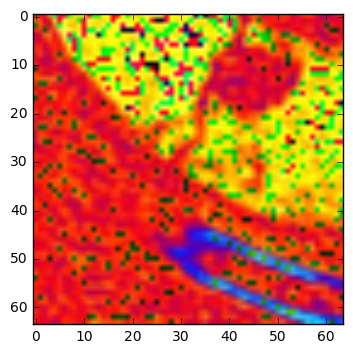

In [92]:
np_img=np.load('/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100/0/0/test_img.npy')
np_lab=np.load('/home/seongjung/바탕화면/Numpy_ASAN/Mal_vs_Benign/100_100/0/0/test_lab.npy')

np_aug_img ,np_aug_lab = aug(np_img[0:1] ,64 , 64 , np_lab[0:1])


In [113]:
print np.shape(np_aug_img)
print np.shape(np.rot90(np_aug_img ,axes=1 ))


(2592, 64, 64, 3)


TypeError: rot90() got an unexpected keyword argument 'axes'

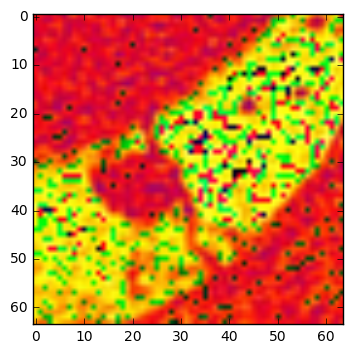

In [90]:
plt.imshow(np_aug_img[1000])

In [144]:
import scipy.ndimage.interpolation as interpolation